In [3]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import lambertw


In [10]:
def mse_ratio(c, q):
    num = (c+1)*(q+1)**2
    denom = (q+c+1) * (q*c+q+1)
    return num / denom

In [11]:
mi_range = [2**(x) for x in range(-7, -3)]
labels = ['1/128', '1/64', '1/32', '1/16', '1/8', '1/4', '1/2', '1', '2', '4']
c_range = [1/(2*mi) for mi in mi_range]
snr_range = [x/1000 for x in range(1, 10000)]

In [12]:
mi_range, c_range

([0.0078125, 0.015625, 0.03125, 0.0625], [64.0, 32.0, 16.0, 8.0])

In [13]:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
plt.rcParams["font.family"] = "Helvetica"

rc('text', usetex=False)

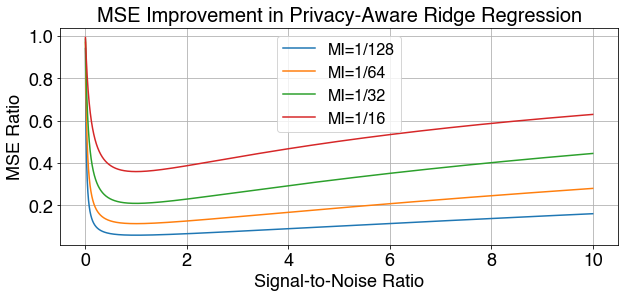

In [14]:
fig, axes = plt.subplots(1, figsize=(10, 4))
for ind, c in enumerate(c_range):
    xs, ys = [], []
    for snr in snr_range:
        xs.append(snr)
        ys.append(mse_ratio(c, snr))
    plt.plot(xs, ys, label=f'MI={labels[ind]}')
    plt.legend(fontsize=16)
axes.grid(True)
axes.tick_params(axis='both', labelsize=18)
plt.xlabel("Signal-to-Noise Ratio", fontsize=18)
plt.ylabel("MSE Ratio", fontsize=18)
plt.title("MSE Improvement in Privacy-Aware Ridge Regression", fontsize=20)
plt.savefig('snr_to_mse.svg')

In [15]:
1/mse_ratio(512, 1)

128.7504873294347

$$\eta_B^* =\frac{1}{\alpha}\big[\frac{\alpha e_0^2}{\beta} + 1 - W(e^{ \frac{\alpha e_0^2}{\beta} + 1})\big],$$
$$\alpha= \mu T$$
$$\beta = \frac{(1+C)\sigma^2}{\mu}$$
$$MSE = (1-\eta \mu)^T e_0^2 + \frac{\eta}{\mu} (C+1) \sigma^2(1-(1-\eta\mu)^T)$$

In [16]:

def solve_for_optimal_eta(mu, sigma_sq, e_0, C, T=32):
    alpha = mu*T
    beta = (1+C) * sigma_sq / mu
    coef = 1./alpha
    first = alpha*e_0**2 / beta
    lambert = lambertw(np.exp(first + 1))
    return coef*(first + 1 - lambert)

def mse_gd(eta, mu, e_0, C, sigma_sq, T=32):
    bias = (1-eta*mu)**T * e_0**2
    var = (eta / mu)*(C+1)*sigma_sq * (1-(1-eta*mu)**T)
    return bias + var

/opt/homebrew/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/var/folders/tn/cp6tfqms4l72brxdjh8krhv80000gn/T/ipykernel_85632/2491931099.py:6: RuntimeWarning: overflow encountered in exp
  lambert = lambertw(np.exp(first + 1))
/var/folders/tn/cp6tfqms4l72brxdjh8krhv80000gn/T/ipykernel_85632/2491931099.py:7: RuntimeWarning: invalid value encountered in scalar multiply
  return coef*(first + 1 - lambert)
/var/folders/tn/cp6tfqms4l72brxdjh8krhv80000gn/T/ipykernel_85632/2491931099.py:10: RuntimeWarning: invalid value encountered in scalar multiply
  bias = (1-eta*mu)**T * e_0**2
/var/folders/tn/cp6tfqms4l72brxdjh8krhv80000gn/T/ipykernel_85632/2491931099.py:11: RuntimeWarning: invalid value encountered in scalar divide
  var = (eta / mu)*(C+1)*sigma_sq * (1-(1-eta*mu)**T)
/var/folders/tn/cp6tfqms4l72brxdjh8krhv80000gn/T/ipykernel_85632/2491931099.py:11: RuntimeWarning: in

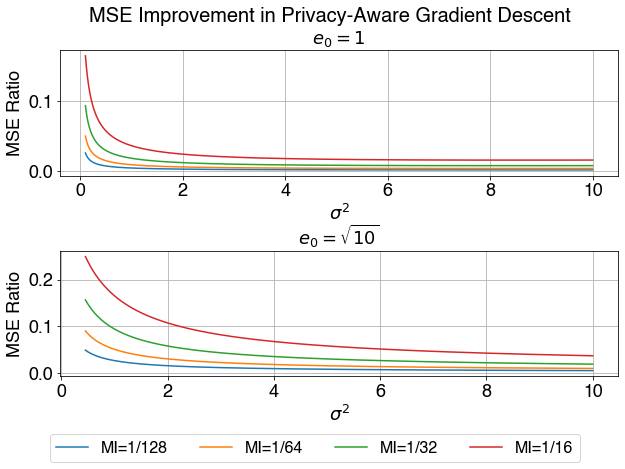

In [17]:

def solve_for_optimal_eta(mu, sigma_sq, e_0, C, T=32):
    alpha = mu*T
    beta = (1+C) * sigma_sq / mu
    coef = 1./alpha
    first = alpha*e_0**2 / beta
    lambert = lambertw(np.exp(first + 1))
    return coef*(first + 1 - lambert)

def mse_gd(eta, mu, e_0, C, sigma_sq, T=32):
    bias = (1-eta*mu)**T * e_0**2
    var = (eta / mu)*(C+1)*sigma_sq * (1-(1-eta*mu)**T)
    return bias + var

mu = 1
L = 1

mi_range = [2**(x) for x in range(-7, -3)]
labels = ['1/128', '1/64', '1/32', '1/16', '1/8', '1/4', '1/2', '1', '2', '4']
c_range = [1/(2*mi) for mi in mi_range]
# c_range = [0]
fig, axes = plt.subplots(2, figsize=(10, 6))
es = [1, 10**0.5]
titles = ["$e_0=1$", "$e_0 = \sqrt{10}$"]
for e_ind, ax in enumerate(axes):
    e_0 = es[e_ind]

    for ind,C in enumerate(c_range):
        C*=32 # per epoch vs. overall

        xs = []
        ys = []
        for sigma_sq in [x/1000 for x in range(100, 10000)]:
            step_size_default = solve_for_optimal_eta(mu, sigma_sq, e_0, 0)

            optimal_eta = solve_for_optimal_eta(mu, sigma_sq, e_0, C)
            if np.isinf(optimal_eta):
                continue
            optimal_mse = mse_gd(optimal_eta, mu, e_0, C, sigma_sq)
            default_mse = mse_gd(step_size_default, mu, e_0, C, sigma_sq)
            xs.append(sigma_sq)
            ys.append(optimal_mse/default_mse)
        ax.plot(xs, ys, label=f'MI={labels[ind]}')
#         print(C, ys)
    ax.grid(True)
    ax.tick_params(axis='both', labelsize=18)
    ax.set_xlabel("$\sigma^2$", fontsize=18)
    ax.set_ylabel("MSE Ratio", fontsize=18)
#     ax.legend(fontsize=16)
    ax.set_title(titles[e_ind], fontsize=18)
plt.subplots_adjust(hspace=0.6)
handles, labels = ax.get_legend_handles_labels()

lgd = fig.legend(handles, labels, ncol=4, loc=2, prop={'size': 16}, bbox_to_anchor=(0.1, 0.01))
plt.suptitle("MSE Improvement in Privacy-Aware Gradient Descent", fontsize=20)
plt.savefig('sigma_sq_to_mse.svg',  bbox_inches = "tight")